# Magnetic skin effect

In [2]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
import numpy as np
from time import sleep
# from ngcotree import * # Bogdan's package
import copy
import matplotlib.pyplot as plt

## 1) Geometry

In [3]:
R = 0.35e-3
geo = SplineGeometry()
geo.AddCircle(c=(0,0),r=R ,leftdomain=1, rightdomain=0, bc = "outer")
mesh = Mesh(geo.GenerateMesh(maxh=R/3)).Curve(3)
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2) Material

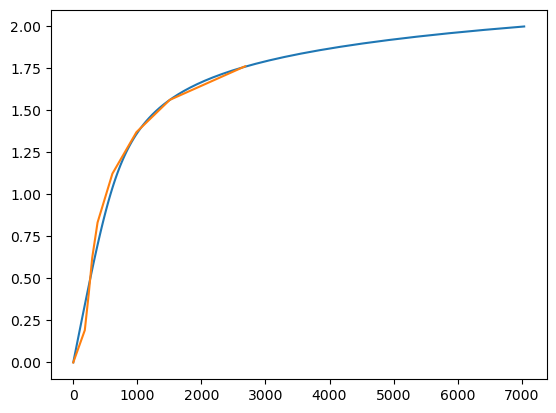

In [4]:
def nuL(b):
    return 1/(10000 * 4e-7* np.pi)

def nuNL(b):
    mu0 = 4e-7*np.pi
    return (1 + 0.05 * exp ( 1.2 * b * b )) /(1600*mu0)


H0 = np.array([0.000000, 180.000000, 242.000000, 296.000000, 379.000000, 611.000000, 986.000000, 1506.000000, 2682.000000 ])
B0 = np.array([0.000000, 0.192000, 0.411000, 0.624000, 0.833000, 1.124000, 1.371000, 1.563000, 1.763000])

B = np.linspace(0.001,2,100)
plt.plot(nuNL(B)*B,B)
plt.plot(H0,B0)
plt.show()

## 2) Formulation

In 2D : find $a\in HCurl(\Omega)$, such as $\forall a^* \in HCurl(\Omega)$
$$\int_\Omega \text{curl}~ a ~\nu~ \text{curl}~ a^* + \int_{\Omega_c} \sigma a^*\cdot \partial_t a =0$$

$$ \Rightarrow M \dot{a} + K(a) a =0  $$

Explicit Euler :
$$ M \frac{a_{n+1} - a_n}{\delta t} + K(a_{n}) a_{n+1} =0  $$

$$ \Rightarrow (M + K(a_{n}) \delta t) a_{n+1} = M a_n  $$


Implicit Euler :
$$ M \frac{a_{n+1} - a_n}{\delta t} + K(a_{n+1}) a_{n+1} =0  $$

$$ \Rightarrow (M + K(a_{n+1}) \delta t) a_{n+1} = M a_n  $$

In [5]:
def solveAV_explicit(mesh, nu, f, Nperiod = 5, NdtPeriod = 10, amplitudeB = 1, sigma = 7.63e6, p = 2):
    
    dt = 1/(f * NdtPeriod)

    ASOL = []
    vol = Integrate(CF(1), mesh) 
    
    # FE Space
    fes = HCurl(mesh, order = p, dirichlet = "outer")
    R, n = CF((0,-1,1,0),dims = (2,2)), specialcf.normal(mesh.dim)
    a, aStar = fes.TnT()
    
    # Mass matrix (does not change)
    M = sigma * aStar * a * dx
    Mass = BilinearForm(M)
    Mass.Assemble()
    gf0 = GridFunction(fes)
    ASOL.append(gf0)
    
    #cotree = CoTreeBitArray(mesh, fes, plot = True)
    
    for i in range(1,Nperiod * NdtPeriod+1):
        
        t = i*dt
        
        # FE matrix
        K = curl(a)*nu(curl(a)) * curl(aStar) * dx
        KK = BilinearForm(M + dt*K)
        KK.Assemble()
        
        # Dirichlet BC
        aSol = GridFunction(fes)
        flux = amplitudeB * sin( 2*np.pi*f*t )  * vol
        aSol.Set(flux * R * n /  Integrate(n*n*ds("outer"),mesh), BND)
        
        # Solving
        r = Mass.mat * ASOL[-1].vec.data - KK.mat * aSol.vec 
        aSol.vec.data += KK.mat.Inverse(freedofs=fes.FreeDofs(), inverse = "sparsecholesky") * r 
        ASOL.append(copy.deepcopy(aSol))
        
        print(f"Computing ... {t/((Nperiod * NdtPeriod)*dt) * 100:.0f} % \r", end="")
        
    return ASOL

p = 1
ASOL = solveAV_explicit(mesh, nuL, p=3, f=500, Nperiod = 2, NdtPeriod = 50, amplitudeB = 1)

In [6]:
def display(solution):
    gfa = solution[0]
    mesh = ASOL[0].space.mesh
    scene = Draw(curl(gfa), mesh)
    i = 0
    for i in range(1,len(solution)):
        gfa.vec.data = solution[i].vec.data
        print(f"\r{i+1}/{len(solution)}         ", end="")
        scene.Redraw()
        sleep(0.1)
display(ASOL)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

101/101         

In [7]:
def Bmeasured(sol):
    B = []
    mesh = sol[1].space.mesh
    R, n = CF((0,-1,1,0),dims = (2,2)), specialcf.normal(mesh.dim)
    vol = Integrate(CF(1), mesh) 
    for i in range(len(sol)):
        B.append(Integrate((R*n)*sol[i] *ds("outer"), mesh) / vol )
    return B

def Hmeasured(sol, nu):
    H = []
    mesh = sol[1].space.mesh
    for i in range(len(sol)):
        h = GridFunction(L2(mesh))
        h.Set(nu(curl(sol[i]))*curl(sol[i]))
        H.append(h(mesh(R-1e-10,0,0)))
    return  H

In [8]:
ASOLL50 = solveAV_explicit(mesh, nuL, p=3, f=50, Nperiod = 2, NdtPeriod = 50, amplitudeB = 1.7)
BavgL50 ,HavgL50 = Bmeasured(ASOLL50) ,  Hmeasured(ASOLL50, nuL)

ASOLL100 = solveAV_explicit(mesh, nuL, p=3, f=100, Nperiod = 2, NdtPeriod =50, amplitudeB = 1.7)
BavgL100 ,HavgL100 = Bmeasured(ASOLL100) ,  Hmeasured(ASOLL100, nuL)

ASOLL300 = solveAV_explicit(mesh, nuL, p=3, f=300, Nperiod = 2, NdtPeriod = 50, amplitudeB = 1.7)
BavgL300 ,HavgL300 = Bmeasured(ASOLL300) ,  Hmeasured(ASOLL300, nuL)

ASOLL500 = solveAV_explicit(mesh, nuL, p=3, f=500, Nperiod = 2, NdtPeriod = 50, amplitudeB = 1.7)
BavgL500 ,HavgL500 = Bmeasured(ASOLL500) ,  Hmeasured(ASOLL500, nuL)

ASOLL1000 = solveAV_explicit(mesh, nuL, p=3, f=1000, Nperiod = 2, NdtPeriod = 50, amplitudeB = 1.7)
BavgL1000 ,HavgL1000 = Bmeasured(ASOLL1000) ,  Hmeasured(ASOLL1000, nuL)

ASOLL2000 = solveAV_explicit(mesh, nuL, p=3, f=2000, Nperiod = 2, NdtPeriod = 50, amplitudeB = 1.7)
BavgL2000 ,HavgL2000 = Bmeasured(ASOLL2000) ,  Hmeasured(ASOLL2000, nuL)

FileNotFoundError: [Errno 2] No such file or directory: 'figures/Hlinear.png'

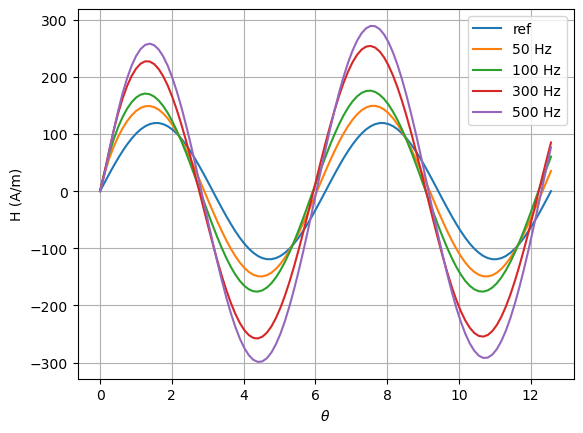

In [9]:
theta = np.linspace(0,4*np.pi, len(HavgL50))
plt.plot(theta, 1.5*nuL(1.5) * np.sin(theta), label = "ref")
plt.plot(theta, HavgL50, label = "50 Hz")
plt.plot(theta, HavgL100, label = "100 Hz")
plt.plot(theta, HavgL300, label = "300 Hz")
plt.plot(theta, HavgL500, label = "500 Hz")
plt.xlabel("$\\theta$ ")
plt.ylabel("H (A/m)")
plt.legend()
plt.grid()
plt.savefig("figures/Hlinear.png")
plt.show()

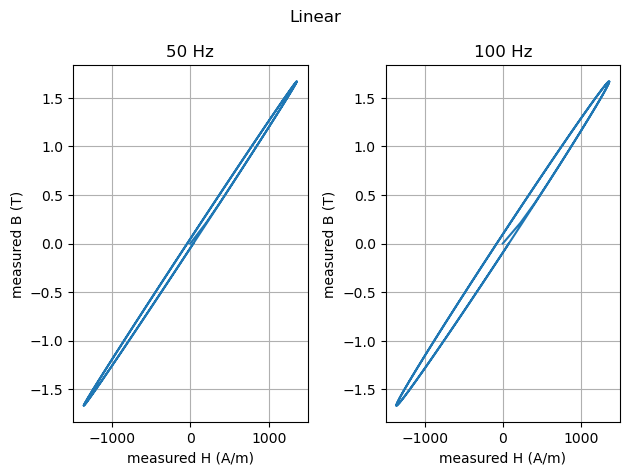

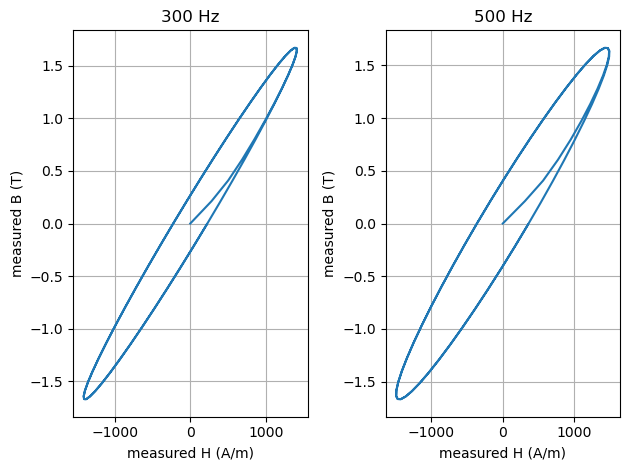

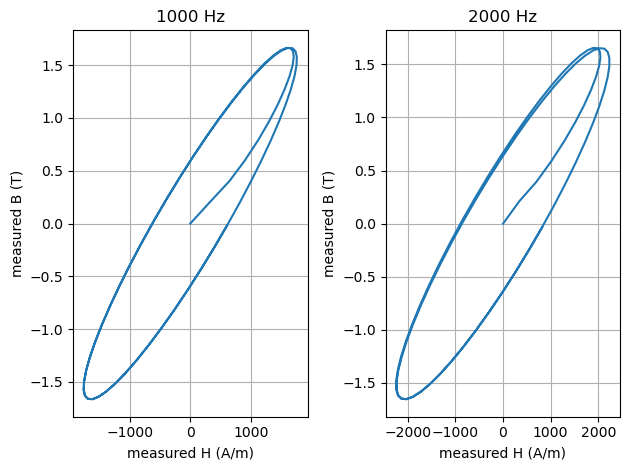

In [29]:
plt.subplot(1,2,1)
plt.suptitle("Linear")
plt.plot(HavgL50,BavgL50)
plt.title("50 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(HavgL100,BavgL100)
plt.title("100 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.plot(HavgL300,BavgL300)
plt.title("300 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(HavgL500,BavgL500)
plt.title("500 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()

plt.show()

plt.subplot(1,2,1)
plt.plot(HavgL1000,BavgL1000)
plt.title("1000 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(HavgL2000,BavgL2000)
plt.title("2000 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()
plt.savefig("figures/hysteresisLinear.png")
plt.show()

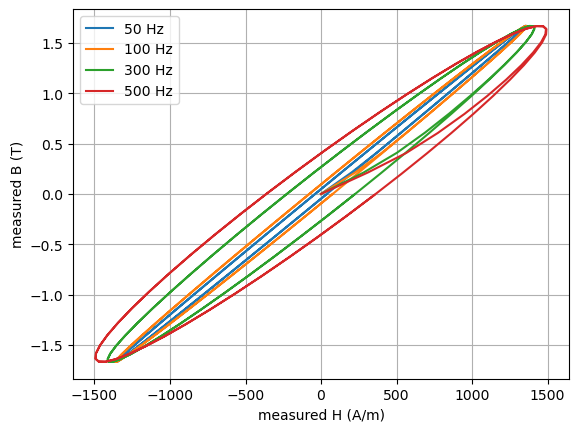

In [30]:
plt.plot(HavgL50,BavgL50, label = "50 Hz")
plt.plot(HavgL100,BavgL100, label = "100 Hz")
plt.plot(HavgL300,BavgL300, label = "300 Hz")
plt.plot(HavgL500,BavgL500, label = "500 Hz")
plt.legend()
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.savefig("figures/hysteresisLinearSuperposed.png")
plt.show()

In [33]:
ASOL50 = solveAV_explicit(mesh, nuNL, p=3, f=50, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg50 ,Havg50 = Bmeasured(ASOL50) ,  Hmeasured(ASOL50, nuNL)

ASOL100 = solveAV_explicit(mesh, nuNL, p=3, f=100, Nperiod = 2, NdtPeriod =100, amplitudeB = 1.7)
Bavg100 ,Havg100 = Bmeasured(ASOL100) ,  Hmeasured(ASOL100, nuNL)

ASOL300 = solveAV_explicit(mesh, nuNL, p=3, f=300, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg300 ,Havg300 = Bmeasured(ASOL300) ,  Hmeasured(ASOL300, nuNL)

ASOL500 = solveAV_explicit(mesh, nuNL, p=3, f=500, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg500 ,Havg500 = Bmeasured(ASOL500) ,  Hmeasured(ASOL500, nuNL)

ASOL1000 = solveAV_explicit(mesh, nuNL, p=3, f=1000, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg1000 ,Havg1000 = Bmeasured(ASOL1000) ,  Hmeasured(ASOL1000, nuNL)

ASOL2000 = solveAV_explicit(mesh, nuNL, p=3, f=2000, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg2000 ,Havg2000 = Bmeasured(ASOL2000) ,  Hmeasured(ASOL2000, nuNL)

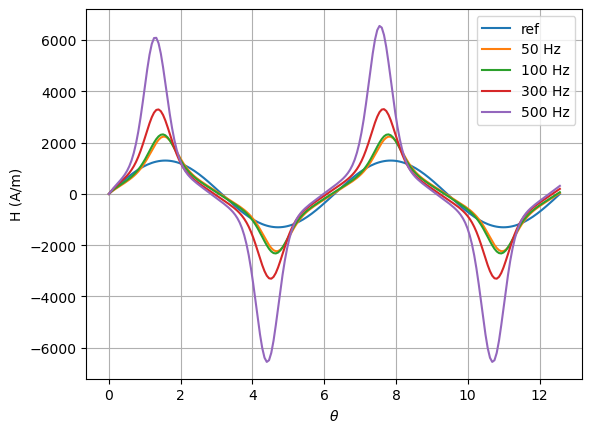

In [34]:
theta = np.linspace(0,4*np.pi, len(Havg50))
plt.plot(theta, 1.5*nuNL(1.5) * np.sin(theta), label = "ref")
plt.plot(theta, Havg50, label = "50 Hz")
plt.plot(theta, Havg100, label = "100 Hz")
plt.plot(theta, Havg300, label = "300 Hz")
plt.plot(theta, Havg500, label = "500 Hz")
plt.xlabel("$\\theta$ ")
plt.ylabel("H (A/m)")
plt.legend()
plt.grid()
plt.savefig("figures/H_NL.png")
plt.show()

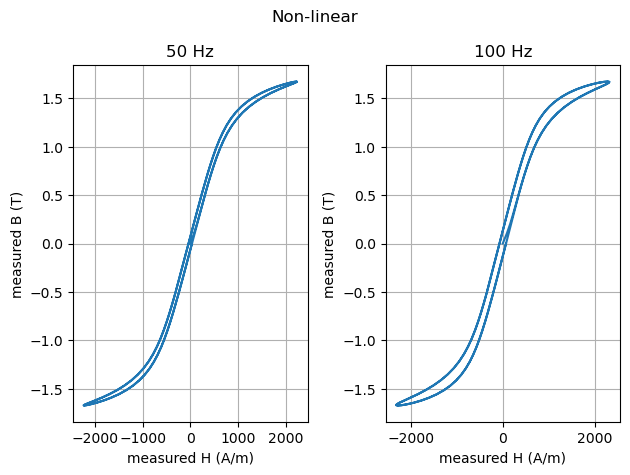

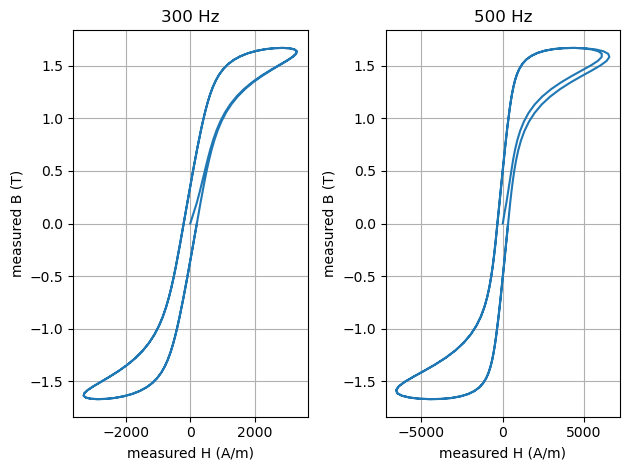

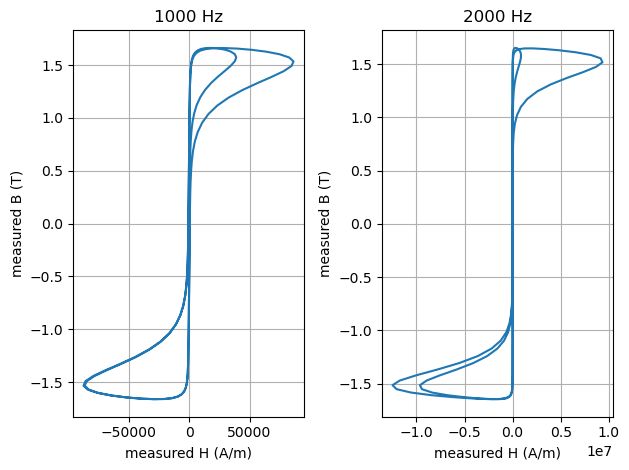

In [35]:
plt.subplot(1,2,1)
plt.suptitle("Non-linear")
plt.plot(Havg50,Bavg50)
plt.title("50 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(Havg100,Bavg100)
plt.title("100 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()
plt.savefig("figures/hysteresisNL1.png")
plt.show()

plt.subplot(1,2,1)
plt.plot(Havg300,Bavg300)
plt.title("300 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(Havg500,Bavg500)
plt.title("500 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()
plt.savefig("figures/hysteresisNL2.png")

plt.show()

plt.subplot(1,2,1)
plt.plot(Havg1000,Bavg1000)
plt.title("1000 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(Havg2000,Bavg2000)
plt.title("2000 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()
plt.savefig("figures/hysteresisNL3.png")
plt.show()

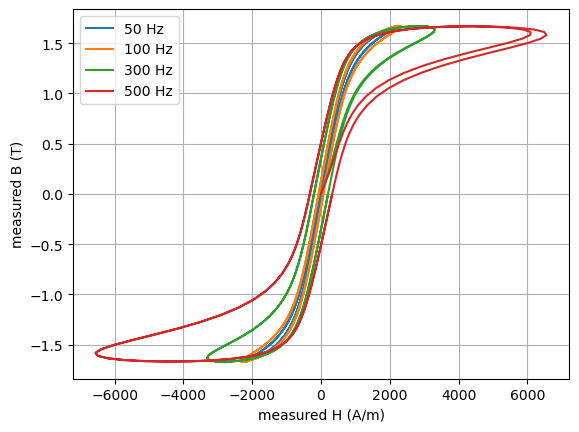

In [14]:
plt.plot(Havg50,Bavg50, label = "50 Hz")
plt.plot(Havg100,Bavg100, label = "100 Hz")
plt.plot(Havg300,Bavg300, label = "300 Hz")
plt.plot(Havg500,Bavg500, label = "500 Hz")
plt.legend()
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.savefig("figures/hysteresisNLSuperposed.png")
plt.show()

In [15]:
display(ASOLL50)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

101/101         

In [16]:
display(ASOLL2000)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

101/101         

In [17]:
display(ASOL50)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

201/201         

In [18]:
display(ASOL2000)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

201/201         

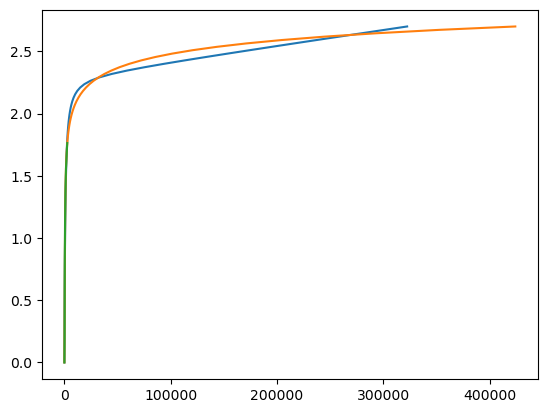

In [41]:
mur0 = 2000
Jsat = 2.3
a = 0.0004
    
def mScalar(normB) :
    slp = 1-1/mur0
    dab = slp/Jsat
    aa = dab*normB
    bb = aa + 1
    cc =  (1-a)
    return Jsat/(2*cc) * ( bb -sqrt( bb**2 - 4*aa * cc ) )
   

def nuNL2(b):
    mu0 = 4e-7 * pi
    normB = sqrt(b*b)
    normeH = (normB - mScalar(normB))/mu0
    return normeH / (normB + 1e-6)

B = np.linspace(0.001,2.7,100)
plt.plot(nuNL2(B)*B,B)
plt.plot(nuNL(B)*B,B)
#plt.plot(B/(4e-7*pi),B)
plt.plot(H0,B0)
plt.show()

In [42]:
ASOL50b = solveAV_explicit(mesh, nuNL2, p=3, f=50, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg50b ,Havg50b = Bmeasured(ASOL50b) ,  Hmeasured(ASOL50b, nuNL2)

ASOL100b = solveAV_explicit(mesh, nuNL2, p=3, f=100, Nperiod = 2, NdtPeriod =100, amplitudeB = 1.7)
Bavg100b ,Havg100b = Bmeasured(ASOL100b) ,  Hmeasured(ASOL100b, nuNL2)

ASOL300b = solveAV_explicit(mesh, nuNL2, p=3, f=300, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg300b ,Havg300b = Bmeasured(ASOL300b) ,  Hmeasured(ASOL300b, nuNL2)

ASOL500b = solveAV_explicit(mesh, nuNL2, p=3, f=500, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg500b ,Havg500b = Bmeasured(ASOL500b) ,  Hmeasured(ASOL500b, nuNL2)

ASOL1000b = solveAV_explicit(mesh, nuNL2, p=3, f=1000, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg1000b ,Havg1000b = Bmeasured(ASOL1000b) ,  Hmeasured(ASOL1000b, nuNL2)

ASOL2000b = solveAV_explicit(mesh, nuNL2, p=3, f=2000, Nperiod = 2, NdtPeriod = 100, amplitudeB = 1.7)
Bavg2000b ,Havg2000b = Bmeasured(ASOL2000b) ,  Hmeasured(ASOL2000b, nuNL2)

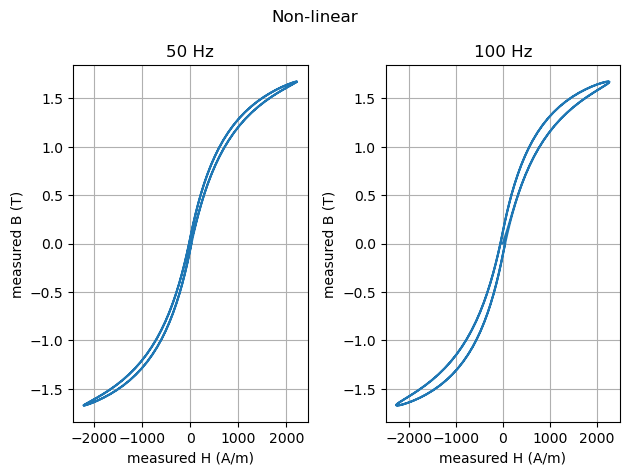

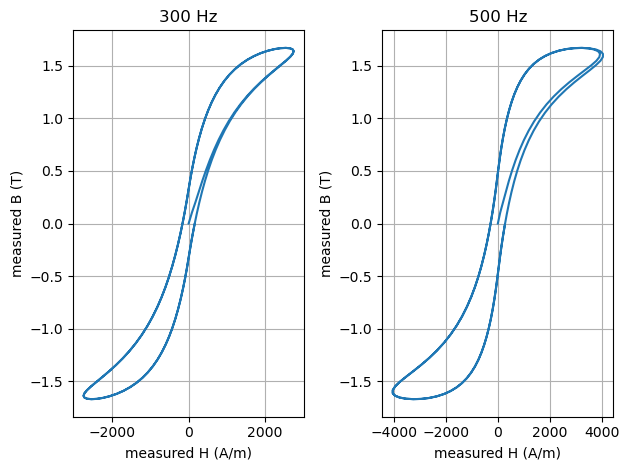

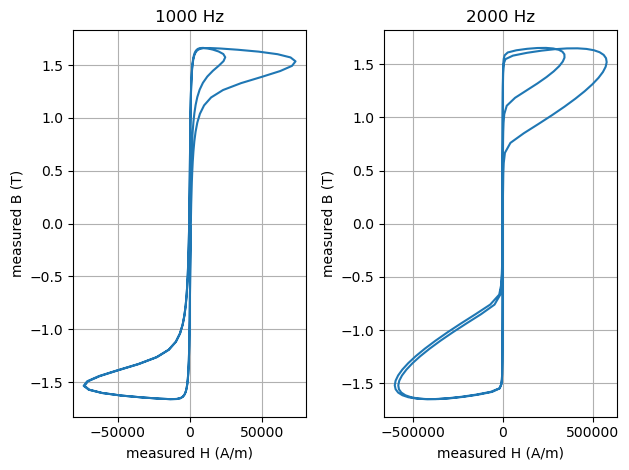

In [44]:
plt.subplot(1,2,1)
plt.suptitle("Non-linear")
plt.plot(Havg50b,Bavg50b)
plt.title("50 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(Havg100b,Bavg100b)
plt.title("100 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()
plt.savefig("figures/hysteresisNL1b.png")
plt.show()

plt.subplot(1,2,1)
plt.plot(Havg300b,Bavg300b)
plt.title("300 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(Havg500b,Bavg500b)
plt.title("500 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()
plt.savefig("figures/hysteresisNL2b.png")
plt.show()

plt.subplot(1,2,1)
plt.plot(Havg1000b,Bavg1000b)
plt.title("1000 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")

plt.subplot(1,2,2)
plt.plot(Havg2000b,Bavg2000b)
plt.title("2000 Hz")
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.tight_layout()
plt.savefig("figures/hysteresisNL3b.png")
plt.show()

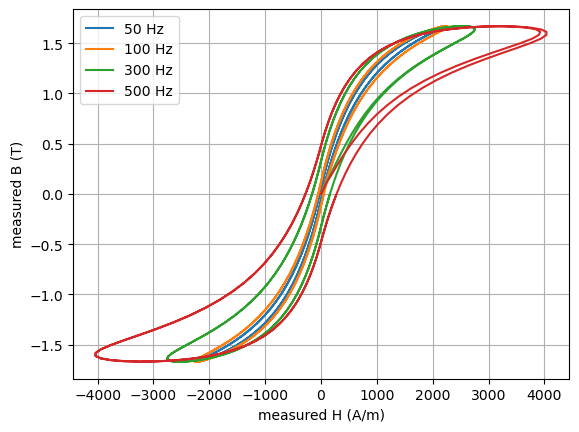

In [22]:
plt.plot(Havg50b,Bavg50b, label = "50 Hz")
plt.plot(Havg100b,Bavg100b, label = "100 Hz")
plt.plot(Havg300b,Bavg300b, label = "300 Hz")
plt.plot(Havg500b,Bavg500b, label = "500 Hz")
plt.legend()
plt.grid()
plt.xlabel("measured H (A/m)")
plt.ylabel("measured B (T)")
plt.savefig("figures/hysteresisNLbSuperposed.png")
plt.show()

In [9]:
R = 0.35e-3
geo = SplineGeometry()
geo.AddCircle(c=(0,0),r=R ,leftdomain=2, rightdomain=1, mat = "iron")
geo.AddCircle(c=(0,0),r=R ,leftdomain=1, rightdomain=0, bc = "outer")

mesh = Mesh(geo.GenerateMesh(maxh=R/3)).Curve(3)
Draw(mesh)

TypeError: Append(): incompatible function arguments. The following argument types are supported:
    1. (self: netgen.libngpy._geom2d.SplineGeometry, point_indices: list, leftdomain: int = 1, rightdomain: int = 0, bc: Optional[Union[int, str]] = None, copy: Optional[int] = None, maxh: float = 1e+99, hpref: float = 0, hprefleft: float = 0, hprefright: float = 0) -> int

Invoked with: <netgen.libngpy._geom2d.SplineGeometry object at 0x00000217100B9F70>, ['spline3', 0, 1, 2]; kwargs: leftdomain=2, rightdomain=1, mat='iron'

In [18]:
a = ASOL[-1]
hGrid  = GridFunction(H1(mesh, order = 2))
hGrid.Set(nuL(curl(a))*curl(a))
Integrate(hGrid, mesh, BND)/Integrate(CF(1), mesh, BND)

-639.8798156874728